# Guiana Chestnut algorithms
This notebook will aim to build several algorithms for fundamental and technical analysis of US stock symbols.

We will be using the [finnhub.io](https://finnhub.io/docs/api) API to download financial data for US stock symbols

### Packages
Please ensure these packages are installed on your local environment via ```pip install -r requirements.txt``` or the corresponding package manager on your OS.

In [20]:
import csv
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt

import finnhub as fh
import spacy

%matplotlib inline

### 0. Essential functions

We first define various functions for gathering the data from finnhub.io which we will use for training our algorithms.

Finnhub.io requires a client object to connect to their API. Please register for a free API key if you don't have one.

In [2]:
key = os.environ.get('FINNHUB_API_KEY')
client = fh.Client(api_key=key)
client

In [11]:
def get_ticker_financial_data(symbol, client):
    """
    Builds a pandas dataframe containing the essential financial data of a US stock symbol.
    @params symbol: a registered US stock symbol (ticker symbol).
    @params client: a finnhub.io Client instance initialized with your finnhub.io API key.
    @return: pandas Dataframe
    """

    # Extract company profile
    company_profile_dict = client.company_profile2(symbol=symbol)
    del company_profile_dict['logo'], company_profile_dict['phone'], company_profile_dict['weburl'], company_profile_dict['ticker']
    company_profile = pd.Series(company_profile_dict)

    # Extract company financial metrics
    company_financials_metrics = client.company_basic_financials(symbol=symbol, metric='all')['metric']
    company_financials = pd.Series(company_financials_metrics)    

    data = pd.concat([company_profile, company_financials])
    return pd.DataFrame(data)

def get_ticker_news_data(symbol, client, date_format, days=7):
    """
    Builds a list of news summaries for a US stock symbol.
    @params symbol: a registered US stock symbol (ticker symbol).
    @params client: a finnhub.io Client instance initialized with your finnhub.io API key.
    @return: List of news headlines for further processing
    """

    today       = datetime.datetime.now(datetime.timezone.utc).replace(tzinfo=datetime.timezone.utc).timestamp()
    date_delta  = today - days * 24 * 60 * 60
    start_date  = datetime.datetime.fromtimestamp(date_delta).strftime(date_format)
    today_date  = datetime.datetime.fromtimestamp(today).strftime(date_format)

    news        = client.company_news(symbol=symbol, _from=start_date, to=today_date)
    return news

### 1. Fundamental analysis on symbol

This section focuses on finding patterns in the financial information of all US symbols (correlations, covariances, etc.).

In [4]:
symbol = 'AAPL'

In [5]:
get_ticker_financial_data(symbol, client)

,0
country,US
currency,USD
exchange,NASDAQ NMS - GLOBAL MARKET
finnhubIndustry,Technology
ipo,1980-12-12
...,...
tangibleBookValuePerShareQuarterly,3.17824
tbvCagr5Y,-17.6806
totalDebt/totalEquityAnnual,238.8104
totalDebt/totalEquityQuarterly,236.9534


### 2. Fundamental - Sentiment analysis on news

We can estimate how positive a news report is using sentiment analysis. This can be useful later on for finding the correlation between the positivity of a piece of news and the price trends of a symbol.

We will be using the spaCy library for performing sentiment analysis on a given piece of news. Run the following command to install the en package which is required for spaCy:

In [6]:
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.6 MB/s eta 0:00:00:00:010:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


With the english package installed, we can now perform sentiment analyisis.

Important sentiment terms:

Polarity refers to the orientation of the expressed statement. It should be a float between 1 (positive) and -1 (negative).

Subjectivity refers to the amount of personal bias in the expressed statement. It should be a float between 0 (personal) and 1 (public).

In [34]:
def get_ticker_news_sentiment_analysis(symbol, client):
    nlp = spacy.load('en_core_web_sm')
    nlp.add_pipe('spacytextblob')

    polarities, subjectivities, dates = [], [], []

    ticker_news = get_ticker_news_data(symbol, client, date_format="%Y-%m-%d")

    for news in reversed(ticker_news):
        news_summary, news_date = news['summary'], news['datetime']
        result = nlp(news_summary)
        news_sentiment = result._.blob.sentiment
        news_polarity, news_subjectivity = news_sentiment.polarity, news_sentiment.subjectivity
        polarities.append(news_polarity)
        subjectivities.append(news_subjectivity)
        dates.append(datetime.datetime.fromtimestamp(news_date).strftime("%Y-%m-%d"))
    
    return polarities, subjectivities, dates

In [35]:
polarities, subjectivities, dates = get_ticker_news_sentiment_analysis(symbol, client)
pd.DataFrame.from_dict({'Date': dates, 'Polarity': polarities, 'Subjectivity': subjectivities})

,Date,Polarity,Subjectivity
0,2022-11-11,0.375000,0.750000
1,2022-11-11,0.125000,0.400000
2,2022-11-11,0.083333,0.144444
3,2022-11-11,-0.169643,0.333929
4,2022-11-11,0.000000,0.000000
...,...,...,...
192,2022-11-18,0.437500,0.937500
193,2022-11-18,0.516667,0.841667
194,2022-11-18,0.009524,0.222619
195,2022-11-18,0.243750,0.718750


Let's also plot the polarities against the dates to see if there is any trend

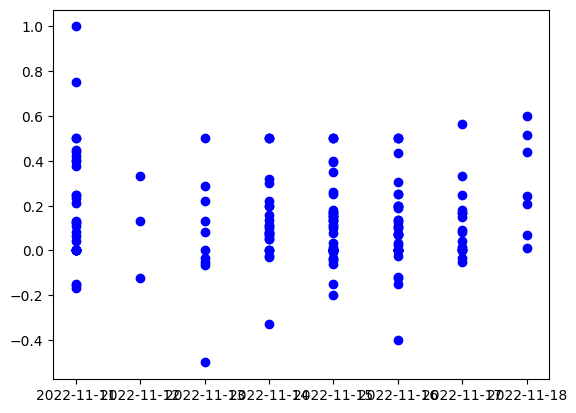

In [36]:
plt.scatter(dates, polarities, c='blue')